In [9]:
import matplotlib.pyplot as plt
from lvmsurveysim import IFU, Telescope
from lvmsurveysim.schedule import ObservingPlan, Simulator, TileDB
from lvmsurveysim.target import TargetList
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, SqrtStretch, ImageNormalize
from astropy import units as u


In [10]:
with open('./Lagoon.yaml', 'r') as f:
    print(f.read())


Lagoon:
  coords: [6, -1.2]
  region_type: rectangle
  frame: galactic
  region_params:
    width: 1.2
    height: 1.0
    pa: 0
  priority: 9
  observatory: LCO
  telescope: LVM-160
  max_airmass: 1.75
  min_shadowheight: 1000.0
  exptime: 900
  n_exposures: 1
  min_exposures: 1
  min_moon_dist: 60
  max_lunation: 1.0
  overhead: 1.1
  tiling_strategy: lowest_airmass
  tile_overlap: 0.02416



In [11]:
targets = TargetList(target_file='./Lagoon.yaml')
print('Tiling Survey ...')
tiledb = TileDB(targets)
tiledb.tile_targets()
tiledb.tile_table.write('Lagoon_tiles.fits', format='fits', overwrite=True)


Tiling Survey ...
Tiling target Lagoon


In [12]:
tbl = tiledb.tile_table
tbl


tile_id,target_index,target,telescope,ra,dec,pa,target_priority,tile_priority,airmass_limit,lunation_limit,hz_limit,moon_distance_limit,total_exptime,visit_exptime
int64,int64,str6,str7,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64
1000001,0,Lagoon,LVM-160,271.5144874877037,-24.486393289337695,659.1899295140049,9,1,1.75,1.0,1000.0,60,900,900
1000002,0,Lagoon,LVM-160,271.1090757696651,-24.705499574539232,299.35612343484786,9,1,1.75,1.0,1000.0,60,900,900
1000003,0,Lagoon,LVM-160,271.5078545741392,-24.057608453409312,659.1952021258185,9,1,1.75,1.0,1000.0,60,900,900
1000004,0,Lagoon,LVM-160,271.1037938983014,-24.27669304677508,659.3594692503395,9,1,1.75,1.0,1000.0,60,900,900
1000005,0,Lagoon,LVM-160,270.6983415300065,-24.49471047826426,299.5271057873995,9,1,1.75,1.0,1000.0,60,900,900
1000006,0,Lagoon,LVM-160,271.09855226577304,-23.84788479476081,659.3613727959005,9,1,1.75,1.0,1000.0,60,900,900
1000007,0,Lagoon,LVM-160,270.6944575115553,-24.065893141515687,659.5270794517132,9,1,1.75,1.0,1000.0,60,900,900


In [13]:
ifu = IFU.from_config()
lvm160 = Telescope.from_config('LVM-160')

In [14]:
lvm160.plate_scale

<Quantity 348.42060811 arcsec / mm>

In [15]:
# Load SHASSA image
dat, hdr = fits.getdata('153.fl.fits.gz', header=True)
wcs = WCS(hdr)
print(dat.shape)


(998, 1014)


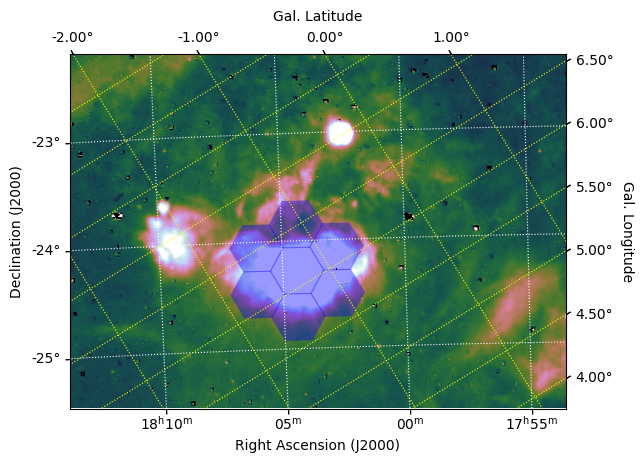

In [31]:
ax = plt.subplot(projection=wcs)
norm = ImageNormalize(dat, interval=PercentileInterval(99),
                      stretch=SqrtStretch())
                      
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.coords[0].set_ticks_position('b')
ax.coords[1].set_ticks_position('l')
ax.grid(color='white', ls=':')
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='yellow', ls=':')
overlay['l'].set_axislabel('Gal. Longitude')
overlay['l'].set_major_formatter('d.dd')
overlay['l'].set_ticks(spacing=0.5 * u.deg)
overlay['l'].set_ticks_position('r')
overlay['l'].set_ticklabel_position('r')
overlay['l'].set_axislabel_position('r')
overlay['b'].set_axislabel('Gal. Latitude')
overlay['b'].set_major_formatter('d.dd')
overlay['b'].set_ticks(spacing=1.0 * u.deg)
overlay['b'].set_ticks_position('t')
overlay['b'].set_ticklabel_position('t')
overlay['b'].set_axislabel_position('t')
ax.set_xlim(550, 900)
ax.set_ylim(50, 300)
for p in tbl:
    patch = ifu.get_patch(scale=lvm160.plate_scale, centre=[p['ra'], p['dec']], pa=p['pa'],
                            edgecolor='None', linewidth=0.0, alpha=0.4, facecolor='b',
                            transform=ax.get_transform('fk5'))[0]
    ax.add_patch(patch)